In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import cluster, confusion_matrix, silhouette_score, adjusted_rand_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./processed-files/df.csv')

In [3]:
df.head()

,Word A,Word B,Relation,Sentence
0,information overload,recommender system,24,The use of mobile devices in combination with ...
1,information overload,recommender system,28,The use of mobile devices in combination with ...
2,information overload,recommender system,24,With the explosive growth of online informatio...
3,information overload,recommender system,28,With the explosive growth of online informatio...
4,information overload,recommender system,24,Only few digital libraries and reference manag...


In [4]:
# 2D array (labelNoStr, labelStr)
conv = np.load('./processed-files/conversion.npy')

labels = df['Relation'].to_numpy()
sentences = df['Sentence'].to_numpy()
word_pairs = df[['Word A', 'Word B']].to_numpy()

embeddings = np.load('./processed-files/fine-tuned_embeddings.npy')

print(f"Imported {len(embeddings)} embeddings")

Imported 1440240 embeddings


In [7]:
embeddings_space = 'all'

if embeddings_space == 'only_words':
    embeddings = embeddings[:, :1536]
elif embeddings_space == 'only_sentences':
    embeddings = embeddings[:, 1536:]

In [8]:
# labels that share the same relationship group
unified_conv_labels = {
    0:0, 2:2, 3:2, 4:2, 5:2, 6:2, 7:7, 8:7, 9:7, 10:10, 11:10, 12:10, 13:10, 15:0, 17:17, 19:17, 20:20, 21:21, 22:21, 23:23, 24:23, 25:23, 27:27, 28:27, 29:27, 30:27, 31:27
    }
# get keys with a value of 0
BROADER = np.array([k for k, v in unified_conv_labels.items() if v == 0])
EVALUATES = np.array([k for k, v in unified_conv_labels.items() if v == 2])
IMPROVES = np.array([k for k, v in unified_conv_labels.items() if v == 7])
INCLUDES = np.array([k for k, v in unified_conv_labels.items() if v == 10])
PREDICTS = np.array([k for k, v in unified_conv_labels.items() if v == 17])
PROVIDES = np.array([k for k, v in unified_conv_labels.items() if v == 20])
REQUIRES = np.array([k for k, v in unified_conv_labels.items() if v == 21])
SUPPORTS = np.array([k for k, v in unified_conv_labels.items() if v == 23])
USES = np.array([k for k, v in unified_conv_labels.items() if v == 27])

# convert np array labels to unified labels using map
unified_labels = np.array([unified_conv_labels[label] for label in labels])
relation_groups = np.unique(unified_labels)

# convert a 2D array conv into a dictionary
conv_dict = {}
for i in range(len(conv)):
    conv_dict[int(conv[i][0])] = conv[i][1]

# !!!!
labels = unified_labels
# !!!!

In [9]:
print('Calculating PCA...')
new_dimension = 70

#Compute PCA on the train embeddings matrix
pca = PCA(n_components=new_dimension)
transformed = pca.fit_transform(embeddings)

Calculating PCA...


In [37]:
# Helper functions
def get_closest_n_points(coordinate, n, same_label=False, label=None, same_cluster=False, cluster_id=None,only_inspected = True):

    # reverse pca to get the original embedding back from coordinate
    coordinate = pca.inverse_transform(coordinate.reshape(1,-1))

    if same_label and label is None:
        raise ValueError('Must specify label if same_label is True')
    if same_cluster and cluster_id is None:
        raise ValueError('Must specify cluster_id if same_cluster is True')

    distances = np.linalg.norm(embeddings - coordinate, axis=1)

    filtered_indexes = set()
    if same_cluster:
        tmp = np.where(kmeans.predict(transformed) != cluster_id)[0]
        filtered_indexes.update(tmp)

    if same_label:
        tmp = np.where(labels != label)[0]
        filtered_indexes.update(tmp)
    
    if only_inspected:
        # get labels indexes that are not in selected_relational_groups
        tmp = np.where(~np.isin(labels, selected_relational_groups))[0]
        filtered_indexes.update(tmp)

    if filtered_indexes:
        filtered_indexes = np.array(list(filtered_indexes))
        print(461885 in filtered_indexes)
        distances[filtered_indexes] = np.inf
    

    sorted_distances = np.argsort(distances)[:n]
    
    if distances[sorted_distances[0]] == np.inf:
        raise ValueError('No points found')
    return sorted_distances

def getInfo(id, cluster_dict=None):
    # if id is a signle integer, return the sentence and the label
    # if id is a list of integers, return the sentences and the labels
    def helper(id, cluster_dict=None):

        if cluster_dict:
            cluster_dict_reversed = {v: k for k, v in cluster_dict.items()}
        label = labels[id] 
        sentence = sentences[id] 
        semantic_type = conv_dict[label]
        predicted_label = kmeans.predict(transformed[id].reshape(1,-1))[0]
        print(f"Sentence (id {id}): {sentence}")
        print(' ')
        print(f"Actual Type: {semantic_type} ")
        print(f"Word A: {word_pairs[id][0]}")
        print(f"Word B: {word_pairs[id][1]}")
        if cluster_dict:
            # int label
            # print(f"Predicted Type: {cluster_dict[predicted_label]}")
            # string label
            print(f"Predicted Type: {conv_dict[cluster_dict[predicted_label]]}")
        else:
            print(f"Predicted Type: {predicted_label}")
        if cluster_dict:
            if label in cluster_dict_reversed:
                reversed_label = cluster_dict_reversed[label]
                print(f"Distance (Actual Centroid) {howFar(transformed[id], kmeans.cluster_centers_[reversed_label])}")
            print(f"Distance (Predicted Centroid) {howFar(transformed[id], kmeans.cluster_centers_[predicted_label])}")
        print("==========")
            
    if isinstance(id, int):
        helper(id, cluster_dict=cluster_dict)
    else:
        for i in id.reshape(-1):
            helper(i, cluster_dict=cluster_dict)

def centroidDistances(centroids):
    # compute the distance between each centroid 
    distances = np.zeros((len(centroids), len(centroids)))
    for i in range(len(centroids)):
        for j in range(len(centroids)):
            distances[i, j] = np.linalg.norm(centroids[i] - centroids[j])
    return distances
    
def nearestOtherCentroid(centroids):
    distances = centroidDistances(centroids)
    return np.partition(distances, 1, axis=1)[:, 1]

def howSimilar(v1, v2):
    # retrun the cosine similarity between the two vectors
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def howFar(v1, v2):
    return np.linalg.norm(v1 - v2)

def purity_score(y_true, y_pred):
    contingency_matrix = cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

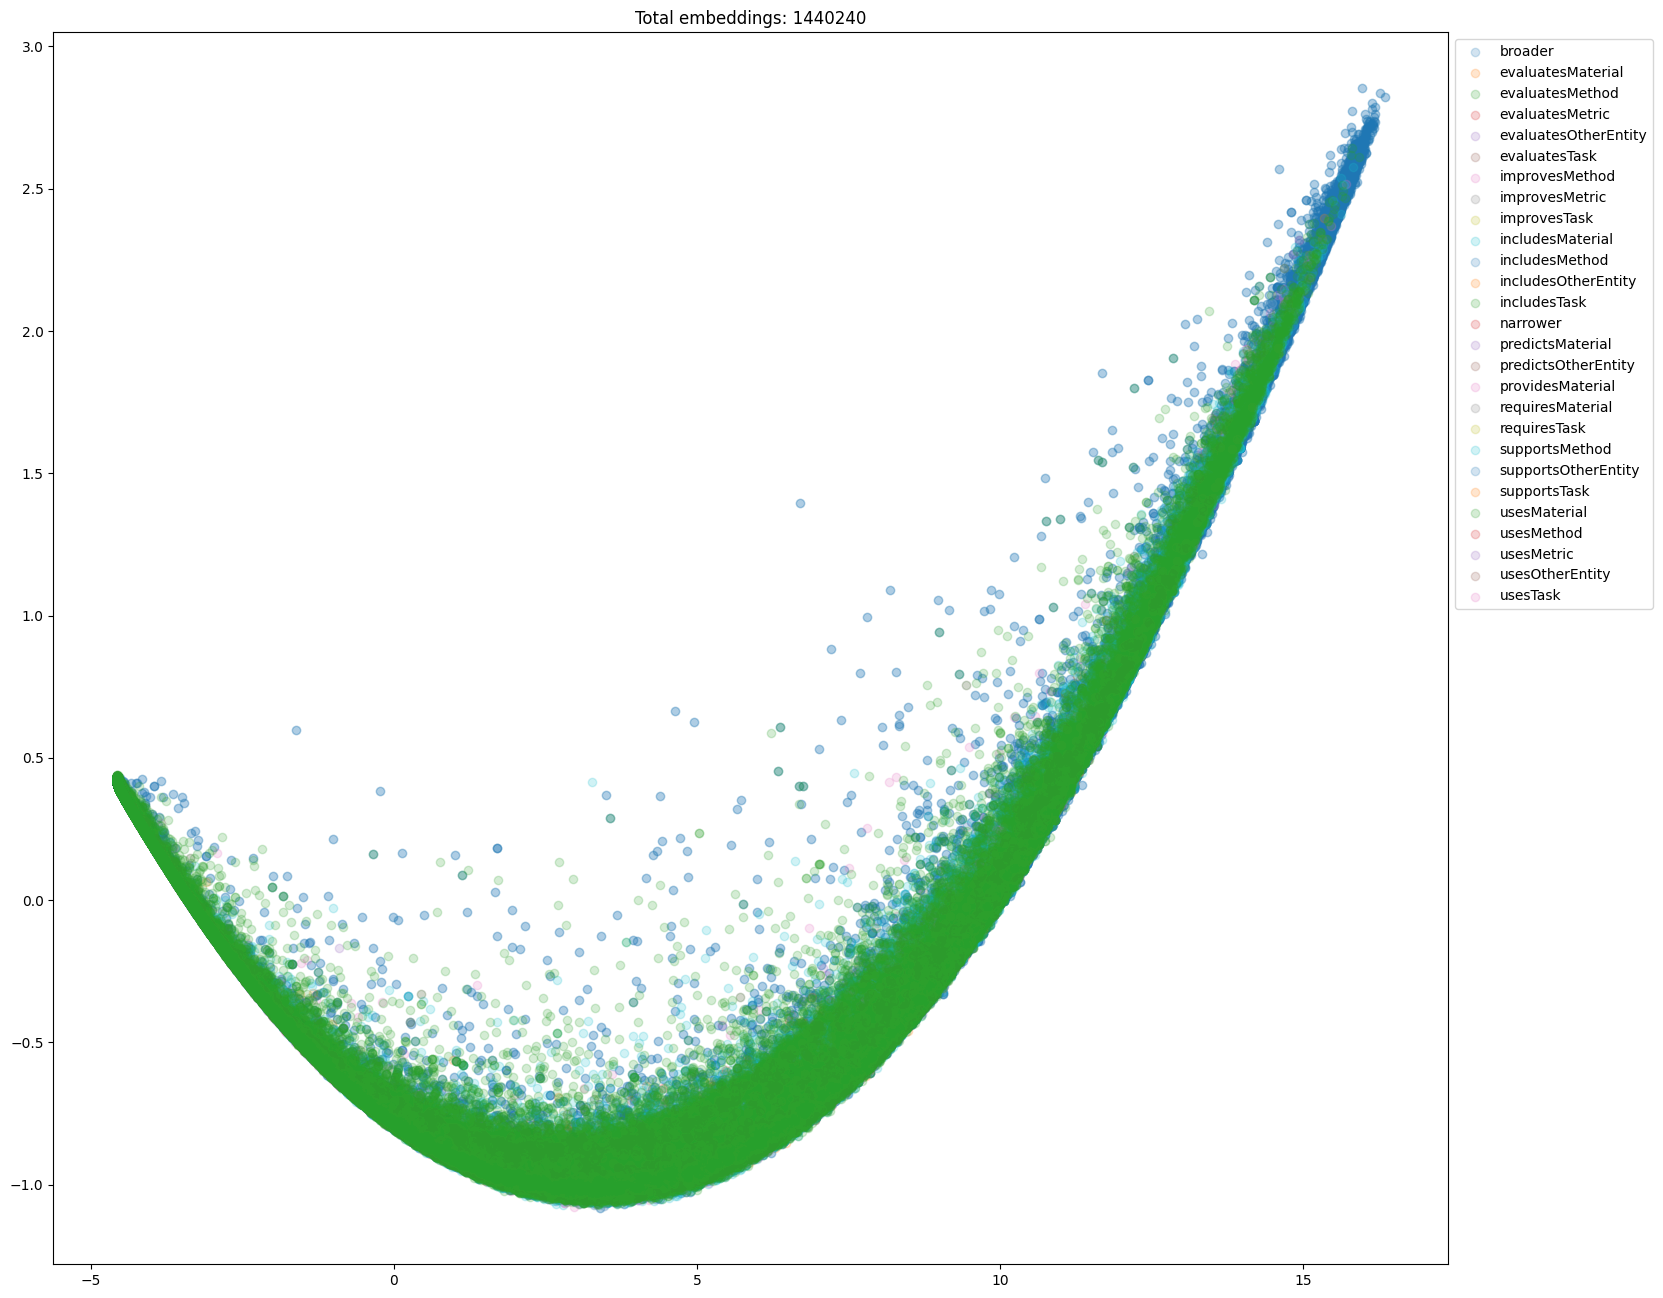

In [17]:
plt.rcParams['figure.figsize'] = [18,16]

def extractFirstCamel(word, on=False):
    if not on:
        return word
    if len(word) == 0:
        return ''
    if word[0].isupper():
        return word[0]
    else:
        for i in range(1, len(word)):
            if word[i].isupper():
                return word[:i]
        return word

# visualize the top 3 principal components on a 3D plot
fig, ax = plt.subplots()

# He you can set the groups that you are interested in.
# Use relation_groups to select all unified groups.
# selected_relational_groups = relation_groups
# this will only keep the first camel word of the group name
# isUnified = True

# Use to conv to select all groups
# selected_relational_groups = conv[:, 0].astype(int)
# or one of the macros: BROADER, EVALUATES, IMPROVES, INCLUDES, PREDICTS, PROVIDES, REQUIRES, SUPPORTS, USES
# selected_relational_groups = np.concatenate((EVALUATES,), axis=0)
selected_relational_groups = conv[:, 0].astype(int)
isUnified = False

# frequencies of each group
# group_frequencies = {group: len(np.where(unified_labels == group)[0]) for group in selected_relational_groups}
# print(group_frequencies)


total = 0
for i in selected_relational_groups:
    selected_labels = np.where(labels[:len(transformed)] == int(i))
    total += len(selected_labels[0])
    ax.scatter(
        transformed[selected_labels, 0],
         transformed[selected_labels, 1],
            alpha=0.2, label=conv_dict[i])

    # title the graph
    ax.set_title(f'Total embeddings: {total}')

# put the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [18]:
# create selected_transformed_indexes which are indexes of the selected relational groups
selected_transformed_indexes = []
for i in selected_relational_groups:
        selected_transformed_indexes.append(np.where(labels == int(i)))

selected_transformed_indexes = np.concatenate(selected_transformed_indexes, axis=1)[0]
selected_transformed = transformed[selected_transformed_indexes]

NameError: name 'purity_score' is not defined

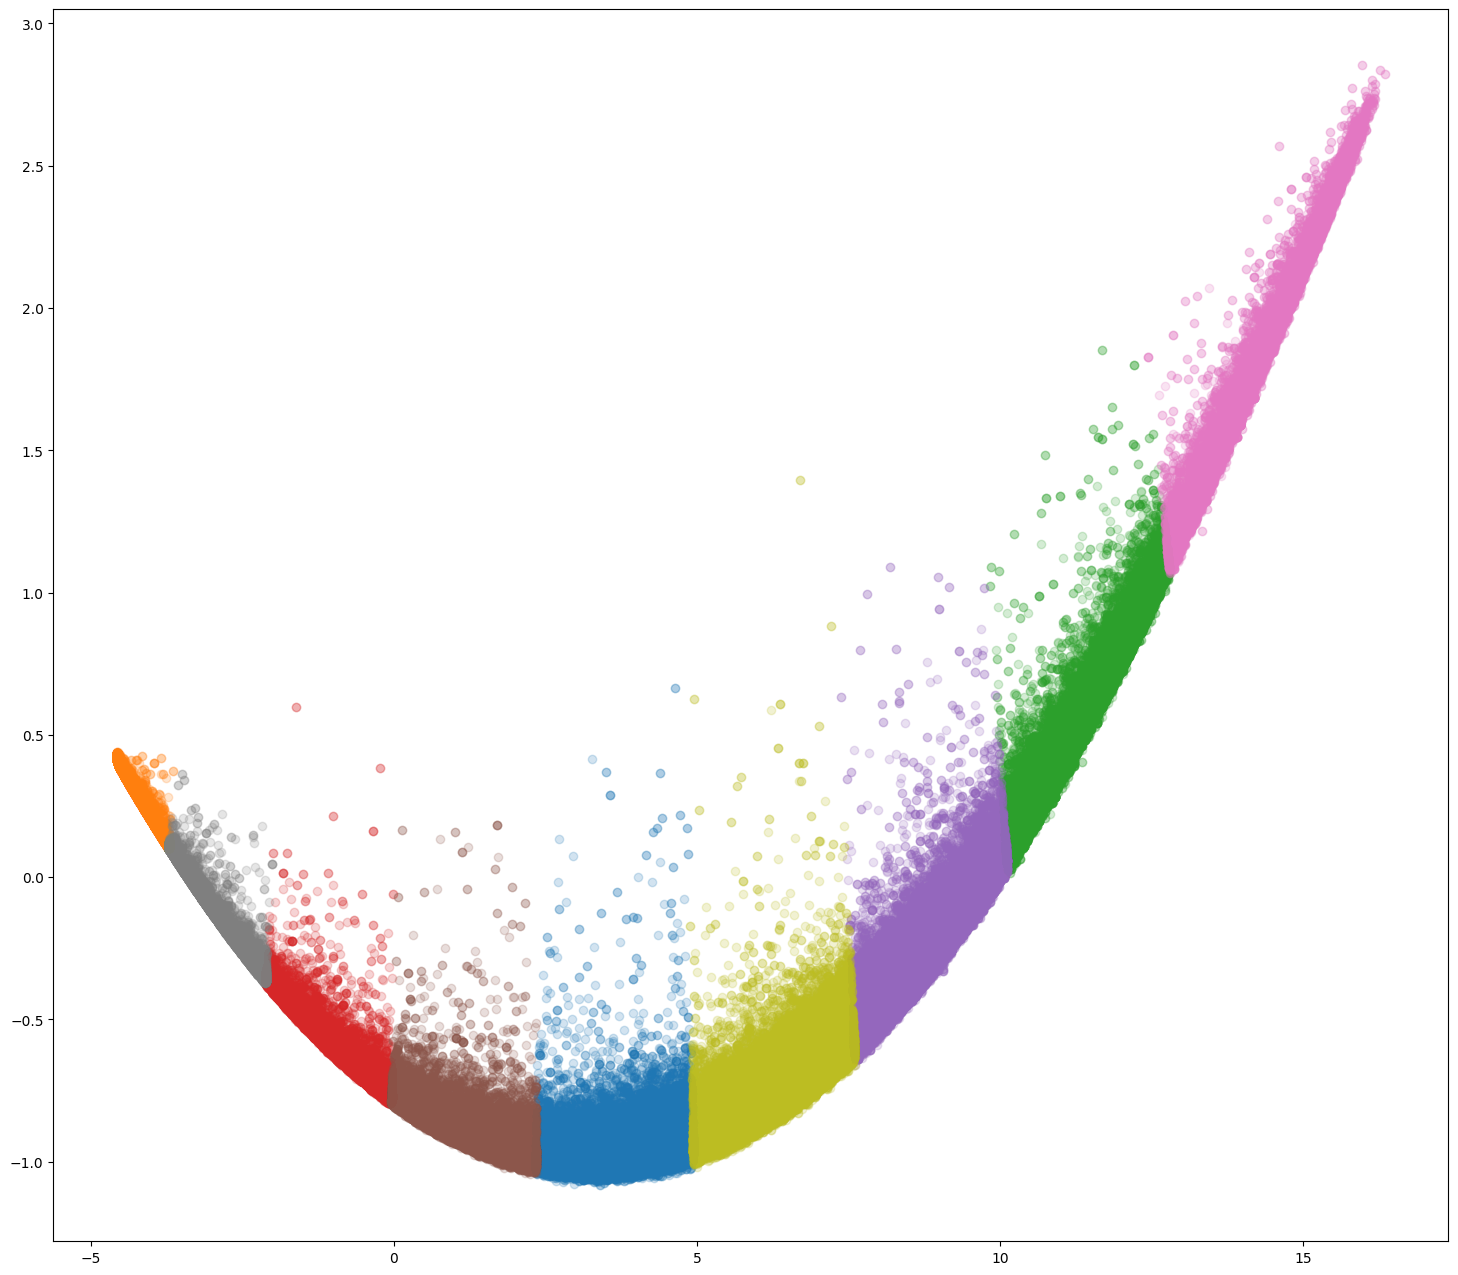

In [19]:
plt.rcParams['figure.figsize'] = [18,16]
# n_relations = len(selected_relational_groups)
n_relations = np.unique(labels[selected_transformed_indexes]).shape[0]
n = 20000
total = 0
kmeans = KMeans(n_clusters=n_relations).fit(selected_transformed)


fig, ax = plt.subplots()
for i in range(n_relations):
    selected_labels = np.where(kmeans.labels_ == i)
    total += len(selected_labels[0])
    ax.scatter(
        selected_transformed[selected_labels, 0],
         selected_transformed[selected_labels, 1],
           label=i,
            alpha=0.2)
        
            
sil_score = silhouette_score(selected_transformed[:n],kmeans.labels_[:n])
pur_score = purity_score(labels[selected_transformed_indexes],kmeans.labels_)
# accuracy =  accuracy_score(labels[selected_transformed_indexes], kmeans.predict(selected_transformed))
ax.set_title(f'Silhouette score: {round(sil_score, 2)} Purity score: {round(pur_score,2)} Total embeddings: {total}')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [18, 120]
n = 5000

silhouette_avg = np.zeros(10)
fig, ax = plt.subplots(8)
for n_relations in range(2, 10):    
    kmeans = KMeans(n_clusters=n_relations).fit(selected_transformed)
    print(n_relations)
    ax[n_relations-2].scatter(selected_transformed[:, 0], selected_transformed[:, 1], c=kmeans.labels_, cmap='rainbow', alpha=0.2)
    silhouette_avg[n_relations] = silhouette_score(selected_transformed[:n], kmeans.labels_[:n])
    print(silhouette_avg[n_relations])

n_relations=len(selected_relational_groups)

In [ ]:
# cluster_dict = {i: selected_relational_groups[i] for i in range(n_relations)}


coord = kmeans.cluster_centers_[0]
# coord = transformed[119756]

# labelno = 3
# clusterno = np.where(selected_relational_groups == labelno)[0][0]

# Print the closest sentences
# indx = get_closest_n_points(coord, 5)

# Print the closest sentences with the same actual label (notice that the predicted cluster might be different)
# indx = get_closest_n_points(coord, 5, same_label=True, label=labelno)

# Print the closest sentences within the same cluster (notice that the actual label might be different)
indx = get_closest_n_points(coord, 20,same_cluster=True, cluster_id=0)

# Print the closest sentences with the same labels within the the same cluster
# indx = get_closest_n_points(coord, 15, same_label=True, label=labelno,same_cluster=True, cluster_id = 0)

getInfo(indx)

In [ ]:
plt.rcParams['figure.figsize'] = [18, 16]
n_relations = len(selected_relational_groups)
n_relations = 2
# plot centroidDistances matrix with labels of the relational groups
fig, ax = plt.subplots()
ax.imshow(centroidDistances(kmeans.cluster_centers_), cmap='hot', interpolation='nearest')

ax.set_xticks(np.arange(n_relations))
ax.set_yticks(np.arange(n_relations))
ax.set_xticklabels(np.arange(n_relations))
ax.set_yticklabels(np.arange(n_relations))

# add labels to the centroidDistances matrix
for i in range(n_relations):
    for j in range(n_relations):
        ax.text(j, i, round(centroidDistances(kmeans.cluster_centers_)[i, j], 2), ha='center', va='center', color='black')
        
# add a string of the relational groups to the centroidDistances matrix on top and on the left side
for i in range(n_relations):
    ax.text(i, -1, extractFirstCamel(conv_dict[selected_relational_groups[i]], on=isUnified), ha='center', va='center', color='red')
    ax.text(-1, i, extractFirstCamel(conv_dict[selected_relational_groups[i]], on=isUnified), ha='center', va='center', color='red')

# Add a title
ax.set_title('Centroid Distances')

plt.show()

In [ ]:
# Calculate the silhouette score on 10% of the data
print('Calculating silhouette score...')

# 50k takes 30s to run
# 67k takes 50s to run
# 92k takes 100s to run

r = 1
randomized_indexes = np.random.randint(0, len(selected_transformed_indexes), size=int(len(selected_transformed_indexes) * r))
transformed_sample = selected_transformed[randomized_indexes]
labels_sample = kmeans.labels_[randomized_indexes]
print(transformed_sample.shape)
print(labels_sample.shape)

silhouette_score_val = silhouette_score(transformed_sample, labels_sample, metric='euclidean')
print(silhouette_score_val)
